In [1]:
library(tidyverse)
library(ggplot2)
library(ggpubr)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package 

In [2]:
esc.AS <- readRDS("/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/RNA_analysis/RDS/esc_AS_remove_neg_904.rds")

In [3]:
intra_prop_B6 <- read_csv("raw_intra_prop_B6_112.csv") %>% rename(index = `...1`)
intra_prop_Cast <- read_csv("raw_intra_prop_Cast_112.csv") %>% rename(index = `...1`)
metadata <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/RNA_analysis/s1014_metadata_X_noM_noXistneg.csv")
tad <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/TAD/new_version/my_tad_filtered_mod_tadE_new.csv") %>% select(-index) %>% rename(index = `...1`)

New names:
• `` -> `...1`
Rows: 112 Columns: 905
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (905): ...1, d0A1, d0A10, d0A11, d0A12, d0A13, d0A14, d0A15, d0A16, d0A1...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 112 Columns: 905
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (905): ...1, d0A1, d0

In [4]:
tad %>% filter(start==5173)

index,start,end,distance,mask
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
110,5173,5185,12,12


In [8]:
intra_prop_B6 <- intra_prop_B6 %>% pivot_longer(!c("index"), names_to = "cellname", values_to = "B6_score") %>% left_join(metadata %>% select(cellname, plot_cluster)) %>% 
    group_by(index, plot_cluster) %>% summarise(B6_score = mean(B6_score, na.rm = TRUE))
intra_prop_Cast <- intra_prop_Cast %>% pivot_longer(!c("index"), names_to = "cellname", values_to = "Cast_score") %>% left_join(metadata %>% select(cellname, plot_cluster)) %>% 
    group_by(index, plot_cluster) %>% summarise(Cast_score = mean(Cast_score, na.rm = TRUE))

Joining with `by = join_by(cellname)`
`summarise()` has grouped output by 'index'. You can override using the `.groups` argument.
Joining with `by = join_by(cellname)`
`summarise()` has grouped output by 'index'. You can override using the `.groups` argument.


In [10]:
intra_prop_Cast <- intra_prop_Cast %>% pivot_wider(values_from = "Cast_score", names_from = "plot_cluster")
intra_prop_B6 <- intra_prop_B6 %>% pivot_wider(values_from = "B6_score", names_from = "plot_cluster")

In [11]:
temp1 <- intra_prop_B6 %>% ungroup %>% select(-index)
temp2 <- intra_prop_Cast %>% ungroup %>% select(-index)
value_prop <- temp1/temp2

In [12]:
value_prop <- value_prop %>% cbind(tad %>% select(c("index", "start", "end"))) %>% na.omit()

In [13]:
mask <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0312_tidyup/prepare/mask_snp_pos.csv")
mask <- mask %>% filter(type == "mapped" & type2 == "SNPrich") %>% mutate(index = pos*1000000/20000)

Rows: 7904 Columns: 3
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): type, type2
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [15]:
value_prop <- value_prop[!is.infinite(rowSums(value_prop)),]

In [16]:
anno <- value_prop %>% select(c("index", "start", "end")) %>% mutate(dist = abs((start+end)/2-5173))

In [17]:
starts <- anno %>% pull(start)
ends <- anno %>% pull(end)

In [18]:
counts <- c()
for(i in 1:nrow(anno)){
    temp_start <- starts[i]
    temp_end <- ends[i]
    fil_region <- mask %>% filter(index >= temp_start & index <= temp_end)
    counts <- c(counts, nrow(fil_region))
}

In [19]:
anno['mask'] <- counts
anno <- anno %>% mutate(ratio = mask/(end-start+1)) %>% filter(ratio > 0.5) %>% mutate(size = end-start+1)

In [20]:
# anno <- anno %>% filter(!index %in% c(111,67))

In [21]:
# anno %>% mutate(size = end-start+1) %>% write_csv("bonev_tad_filtered.csv")

In [50]:
plot <- value_prop %>% filter(index %in% (anno %>% pull(index))) %>% arrange(start) %>% select(!c("index", "start", "end"))

# plot

In [51]:
library(ComplexHeatmap)

In [52]:
library(circlize)
# breaks = c(0.15,0.3,0.55,0.75,1.15)
# color_func = colorRamp2(breaks, rev(c('#b2182b','#fddbc7','#d1e5f0','#67a9cf','#2166ac')))

breaks = c(0.2,0.65,1.15)
color_func = colorRamp2(breaks, c("#DADADA","#ffffff", "#d8433c"))

# color_func = colorRamp2(breaks, c("#2166ac","#4393c3","#f7f7f7", "#d6604d","#b2182b"))
color_func_dis_to_Xist = colorRamp2(c(0,100,200,400,800,1500,2500,3500,4000), c('#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494','#081d58'))

In [53]:
# rowAnno <- HeatmapAnnotation(df = anno %>% arrange(start) %>% select(dist),
#                              col = list(dist = color_func_dis_to_Xist),which = "row")

In [54]:
plot <- plot %>% as.data.frame()
names(plot) <- c(paste0("C",c(0,1,2,3,4,5)))

In [66]:
options(repr.plot.width=2.5,repr.plot.height=5,repr.plot.res=300)
set.seed(42)
pdf("figures_raw_score/fig2G_heatmap.pdf", width=2, height=5)
hm <- Heatmap(plot %>% select(C0,C1,C2,C4,C5), 
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        show_row_names = FALSE, 
        show_column_names = TRUE,
        use_raster=TRUE,
        # left_annotation = rowAnno,
        col = color_func,
        border = FALSE,
        name = "B6/Cast\nTAD score")
hm <- draw(hm)
dev.off()

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


png 
  2

`summarise()` has grouped output by 'type'. You can override using the `.groups` argument.


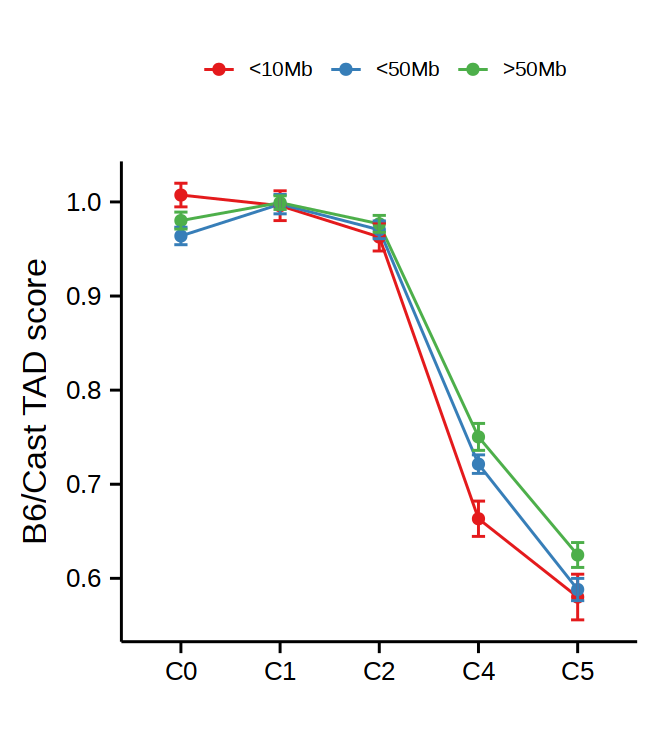

In [65]:
options(repr.plot.width=2.2,repr.plot.height=2.5,repr.plot.res=300)
p <- plot %>% cbind(anno) %>% mutate(type = ifelse(dist < 500, "<10Mb", ifelse(dist < 2500, "<50Mb", ">50Mb"))) %>%
    filter(!index %in% c(110,109,0)) %>%
    select(c(paste0("C", c(0,1,2,4,5)), "type")) %>% 
    pivot_longer(cols = !c("type"), names_to = "cluster", values_to = "value") %>% 
    group_by(type, cluster) %>% summarise(mean = mean(value), sd = sd(value), n = n(), se = sd/sqrt(n)) %>%
    ggplot(aes(x=cluster, y=mean, group=type, color=type)) + 
    geom_line(size = 0.25) +
    geom_point(size = 0.6)+
    geom_errorbar(aes(ymin=mean-se, ymax=mean+se), width=.4,linewidth = 0.25,
                position=position_dodge(0))  + labs(x="", y = "B6/Cast TAD score")+ scale_colour_manual(values=c('#e41a1c','#377eb8','#4daf4a'),name = "") +
    theme_classic() +
    theme(legend.position = "top",
      text = element_text(family="Arial", size=6),
      panel.border = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_line(color="black", linewidth = 0.25),
      axis.ticks = element_line(color="black", linewidth = 0.25),
      axis.text = element_text(color="black",size=6),
      legend.key = element_rect(colour = NA),
      legend.key.width = unit(0.3, "cm"),
      legend.key.height = unit(0.4, "cm"),
      axis.title=element_text(color="black",size=8,face="plain"),
  )
p

ggsave("figures_raw_score/fig2H_tad_decay_distance_to_xist.svg", width = 2.2, height = 2.5, units = "in", dpi = 300)  